<a href="https://colab.research.google.com/github/Shahwaiz9/Final_Year_Project/blob/main/CNNFYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Path to the zip file on Google Drive
zip_path = '/content/drive/MyDrive/FypDataSetPlantVillage/Tomato.zip'

# Directory to unzip the dataset
unzip_dir = '/content/dataset'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print("Dataset unzipped successfully!")


Dataset unzipped successfully!


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

Found 10 disease categories in the dataset directory.
Folder 'Tomato_Early_blight' contains 1000 images.
Folder 'Tomato_Spider_mites_Two_spotted_spider_mite' contains 1676 images.
Folder 'Tomato_Late_blight' contains 1909 images.
Folder 'Tomato_healthy' contains 1591 images.
Folder 'Tomato_Septoria_leaf_spot' contains 1771 images.
Folder 'Tomato__Tomato_YellowLeaf__Curl_Virus' contains 3209 images.
Folder 'Tomato__Tomato_mosaic_virus' contains 373 images.
Folder 'Tomato_Leaf_Mold' contains 952 images.
Folder 'Tomato_Bacterial_spot' contains 2127 images.
Folder 'Tomato__Target_Spot' contains 1404 images.
Found 11212 images belonging to 10 classes.
Found 4799 images belonging to 10 classes.
Class Labels and Indices: {'Tomato_Bacterial_spot': 0, 'Tomato_Early_blight': 1, 'Tomato_Late_blight': 2, 'Tomato_Leaf_Mold': 3, 'Tomato_Septoria_leaf_spot': 4, 'Tomato_Spider_mites_Two_spotted_spider_mite': 5, 'Tomato__Target_Spot': 6, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 7, 'Tomato__Tomato_mosai

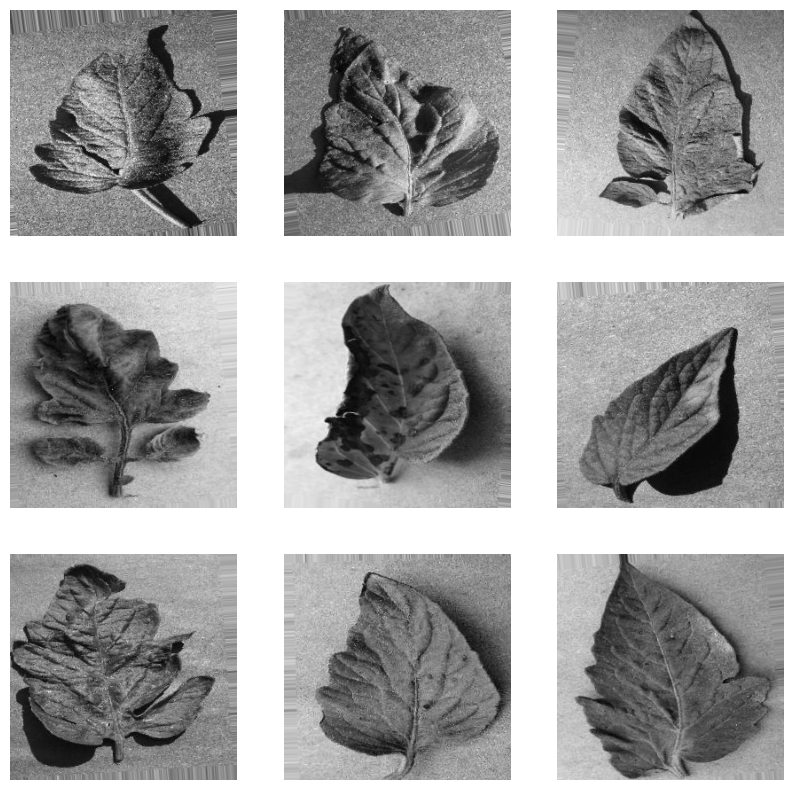

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the dataset directory
dataset_dir = '/content/dataset/Tomato/'

# Check the number of subfolders in the Tomato directory (i.e., different disease categories)
subfolders = os.listdir(dataset_dir)
print(f"Found {len(subfolders)} disease categories in the dataset directory.")

# Check if each subfolder contains images
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_dir, subfolder)
    if os.path.isdir(subfolder_path):
        images_in_subfolder = len(os.listdir(subfolder_path))
        print(f"Folder '{subfolder}' contains {images_in_subfolder} images.")

# Image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=10,  # Lower rotation for subtle changes
    width_shift_range=0.05,  # Minor width shift
    height_shift_range=0.05,  # Minor height shift
    shear_range=0.05,  # Lower shear to preserve details
    zoom_range=0.05,  # Lower zoom to prevent feature distortion
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',  # Ensure grayscale images
    class_mode='categorical',
    subset='training',
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',  # Ensure grayscale images
    class_mode='categorical',
    subset='validation',
)

# Display class labels and indices
class_labels = train_generator.class_indices
print("Class Labels and Indices:", class_labels)

# Check if the data is split correctly and labels are assigned
print(f"Training data has {train_generator.samples} samples and {train_generator.num_classes} classes.")
print(f"Validation data has {validation_generator.samples} samples and {validation_generator.num_classes} classes.")

# Get a batch of images and labels from the train generator
images, labels = next(train_generator)

# Plot a few images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):  # Displaying 9 images as an example
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # Use .squeeze() to remove channel dimension
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),  # Grayscale input
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training with early stopping
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 126s 325ms/step - accuracy: 0.2977 - loss: 2.0116 - val_accuracy: 0.5797 - val_loss: 1.2405
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 137s 336ms/step - accuracy: 0.5147 - loss: 1.3742 - val_accuracy: 0.6251 - val_loss: 1.0628
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 128s 298ms/step - accuracy: 0.5653 - loss: 1.2142 - val_accuracy: 0.6926 - val_loss: 0.8943
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 143s 302ms/step - accuracy: 0.6115 - loss: 1.1084 - val_accuracy: 0.6414 - val_loss: 0.9827
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 108s 302ms/step - accuracy: 0.6394 - loss: 1.0242 - val_accuracy: 0.7145 - val_loss: 0.8020
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 141s 301ms/step - accuracy: 0.6520 - loss: 0.9677 - val_accuracy: 0.7495 - val_loss: 0.7146
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 142s 303ms/step - accuracy: 0.6679 - loss: 0.9421 - val_accuracy: 0.7322 - val_loss: 0.7668
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 307ms/step - accuracy: 0.6816 - loss: 0.88

In [ ]:
# Evaluate on validation data
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - accuracy: 0.8381 - loss: 0.4790
Validation Loss: 0.4947830140590668
Validation Accuracy: 0.8366326093673706


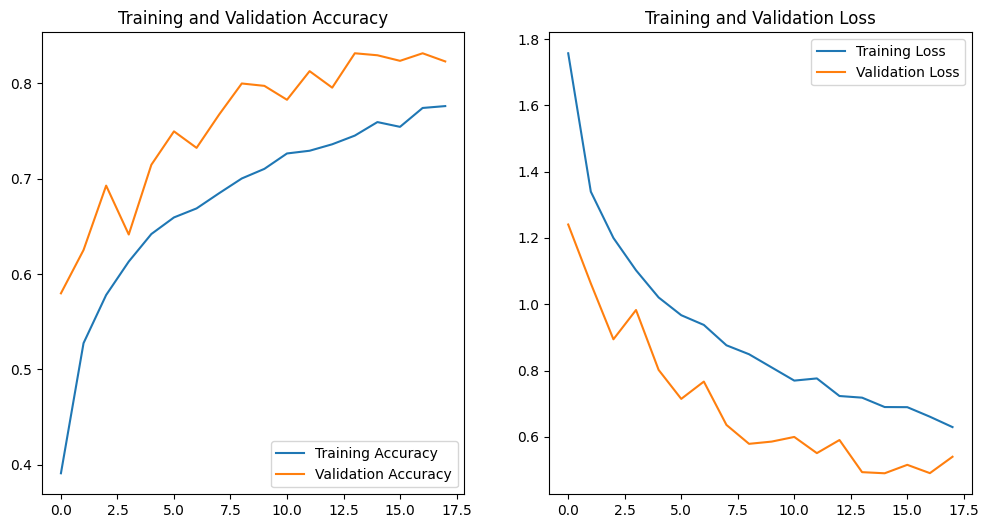

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is defined from your training process

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the actual number of epochs from the history object
epochs_range = range(len(acc)) # This fixes the mismatch in lengths

plt.figure(figsize=(12, 6))
# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 193ms/step
Number of misclassified images: 4230


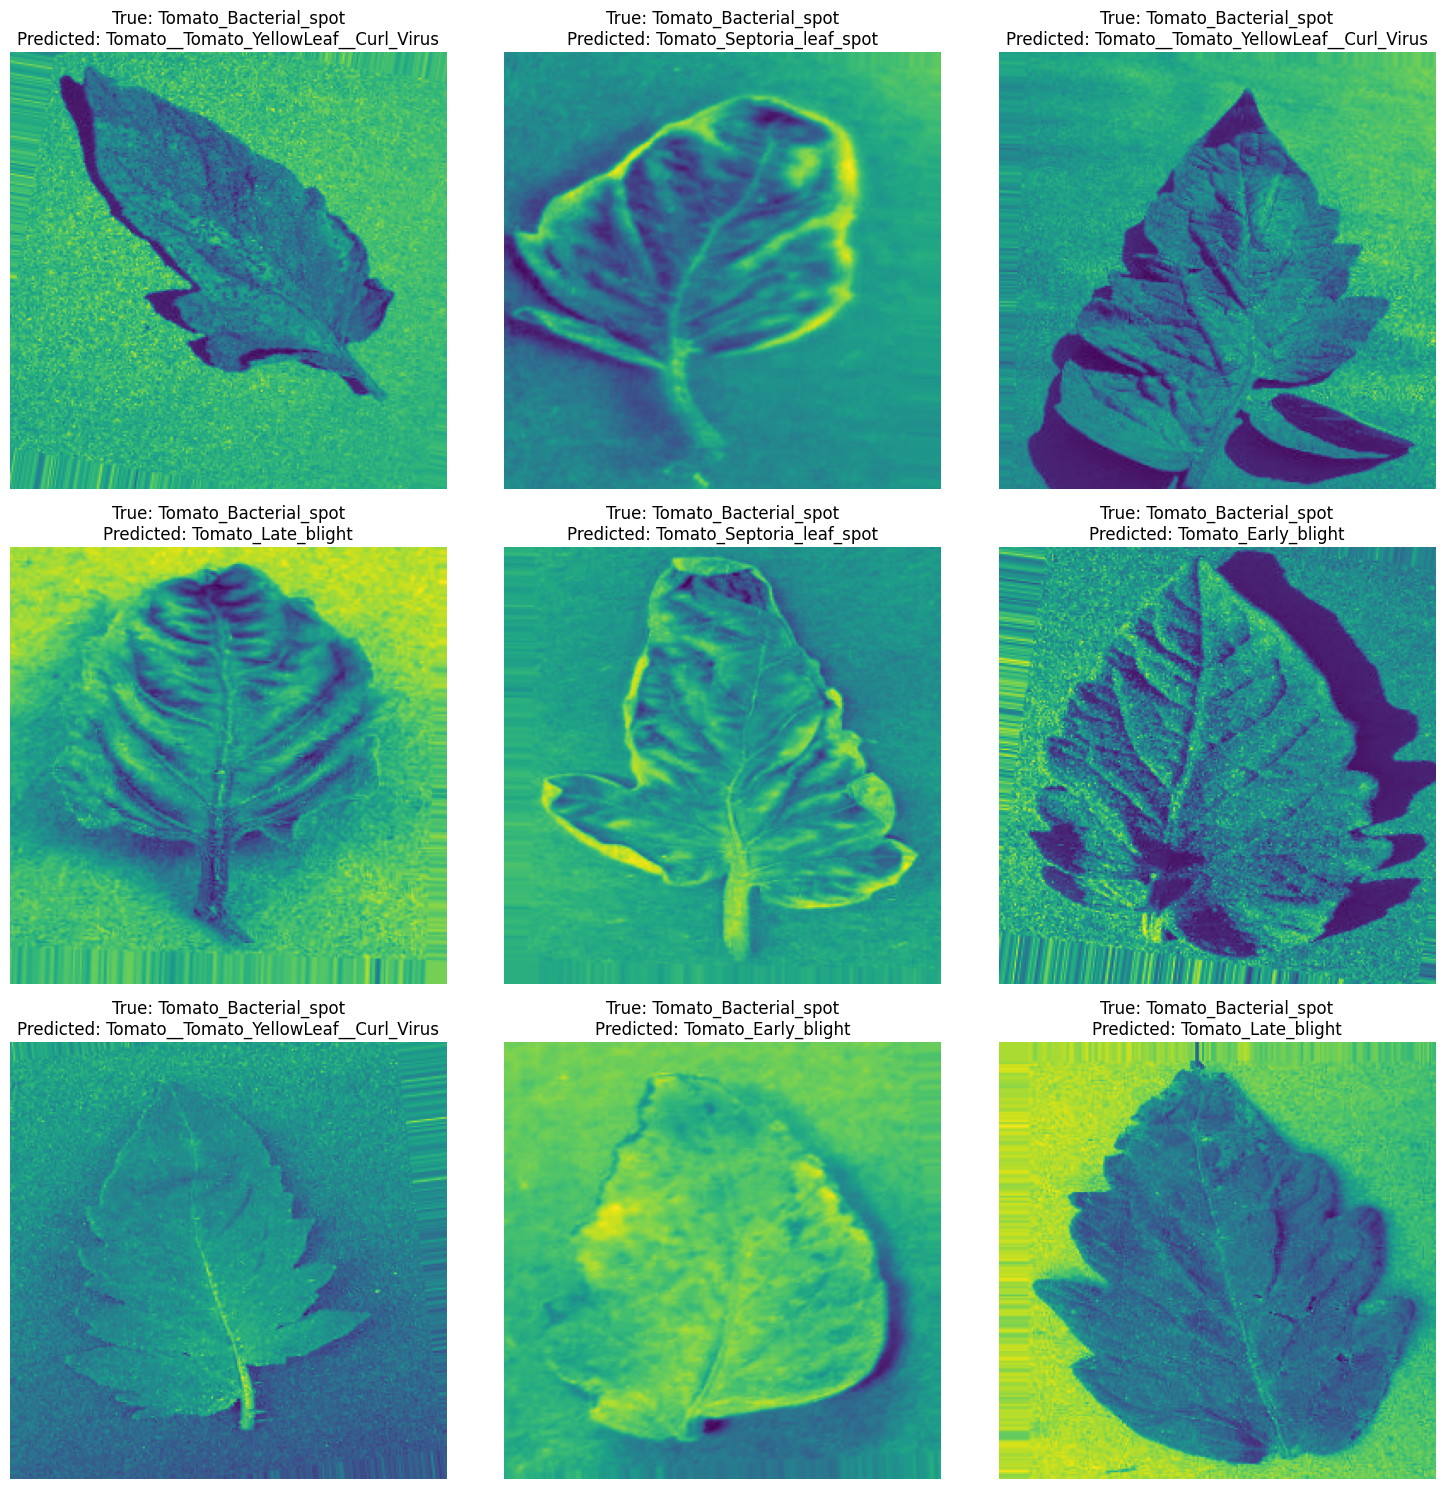

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy library and assign it to alias np

validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Find misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]

print(f"Number of misclassified images: {len(misclassified_indices)}")
# Display a few misclassified images
plt.figure(figsize=(15, 15))  # Increase figure size for better clarity
for i, idx in enumerate(misclassified_indices[:9]):
    img, label = validation_generator[idx]  # Correctly unpack the image and label
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])  # img[0] is used to display the first image in the batch
    true_label = class_labels[true_classes[idx]]
    predicted_label = class_labels[predicted_classes[idx]]
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=12)  # Use multi-line title for clarity
    plt.axis('off')

plt.tight_layout()  # Adjust layout to minimize overlap
plt.show()

Found 10 disease categories in the dataset directory.
Folder 'Tomato_Early_blight' contains 1000 images.
Folder 'Tomato_Spider_mites_Two_spotted_spider_mite' contains 1676 images.
Folder 'Tomato_Late_blight' contains 1909 images.
Folder 'Tomato_healthy' contains 1591 images.
Folder 'Tomato_Septoria_leaf_spot' contains 1771 images.
Folder 'Tomato__Tomato_YellowLeaf__Curl_Virus' contains 3209 images.
Folder 'Tomato__Tomato_mosaic_virus' contains 373 images.
Folder 'Tomato_Leaf_Mold' contains 952 images.
Folder 'Tomato_Bacterial_spot' contains 2127 images.
Folder 'Tomato__Target_Spot' contains 1404 images.
Found 9611 images belonging to 10 classes.
Found 6400 images belonging to 10 classes.
Found 6400 images belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 100s 311ms/step - accuracy: 0.2397 - loss: 2.0794 - val_accuracy: 0.5581 - val_loss: 1.2403 - learning_rate: 0.0010
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 89s 293ms/step - accuracy: 0.5774 - loss: 1.2931 - val_accuracy: 0.6933 - val_loss: 0.9163 - learning_rate: 0.0010
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 89s 294ms/step - accuracy: 0.6864 - loss: 0.9129 - val_accuracy: 0.7541 - val_loss: 0.7082 - learning_rate: 0.0010
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 142s 294ms/step - accuracy: 0.7404 - loss: 0.7837 - val_accuracy: 0.8109 - val_loss: 0.5459 - learning_rate: 0.0010
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 150s 317ms/step - accuracy: 0.7747 - loss: 0.6538 - val_accuracy: 0.7862 - val_loss: 0.6080 - learning_rate: 0.0010
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 89s 293ms/step - accuracy: 0.8099 - loss: 0.5682 - val_accuracy: 0.8620 - val_loss: 0.4067 - learning_rate: 0.0010
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 142s 289ms/step - accuracy: 0.8285 - l

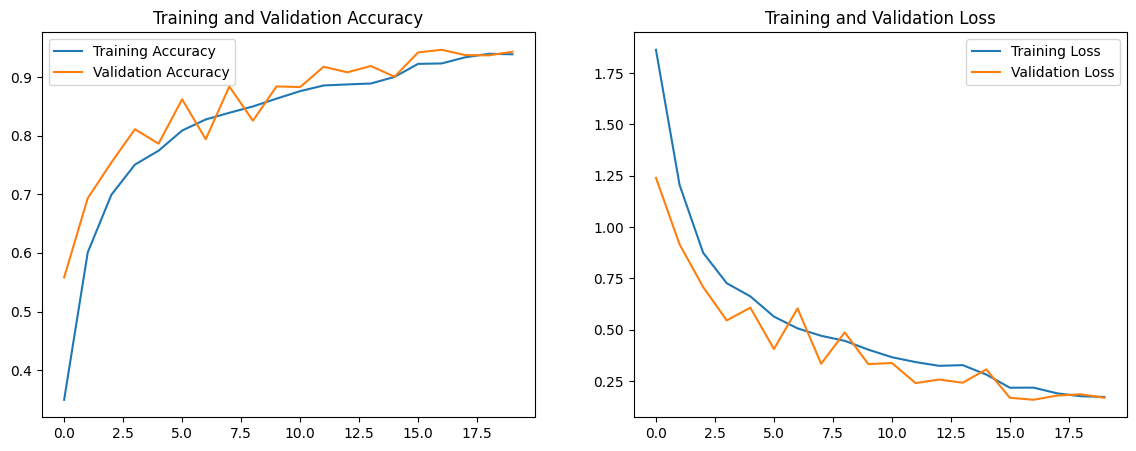

In [ ]:

# Path to the dataset directory
data_dir = '/content/dataset/Tomato/'

# Check the number of subfolders in the Tomato directory (i.e., different disease categories)
subfolders = os.listdir(dataset_dir)
print(f"Found {len(subfolders)} disease categories in the dataset directory.")

# Check if each subfolder contains images
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_dir, subfolder)
    if os.path.isdir(subfolder_path):
        images_in_subfolder = len(os.listdir(subfolder_path))
        print(f"Folder '{subfolder}' contains {images_in_subfolder} images.")


# Image data generator for data augmentation and loading data with class imbalance handling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4,  # 20% validation, 20% test
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Load training, validation, and test sets
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

test_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False  # No shuffling for test set
)

# Compute class weights for handling class imbalance
class_labels = list(train_data.class_indices.keys())
class_weights = compute_class_weight(
    'balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights = dict(enumerate(class_weights))

# CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate on test set
test_data.reset()
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Get true and predicted labels for F1 score and classification report
test_data.reset()
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=-1)

# Calculate accuracy and F1-score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 171ms/step


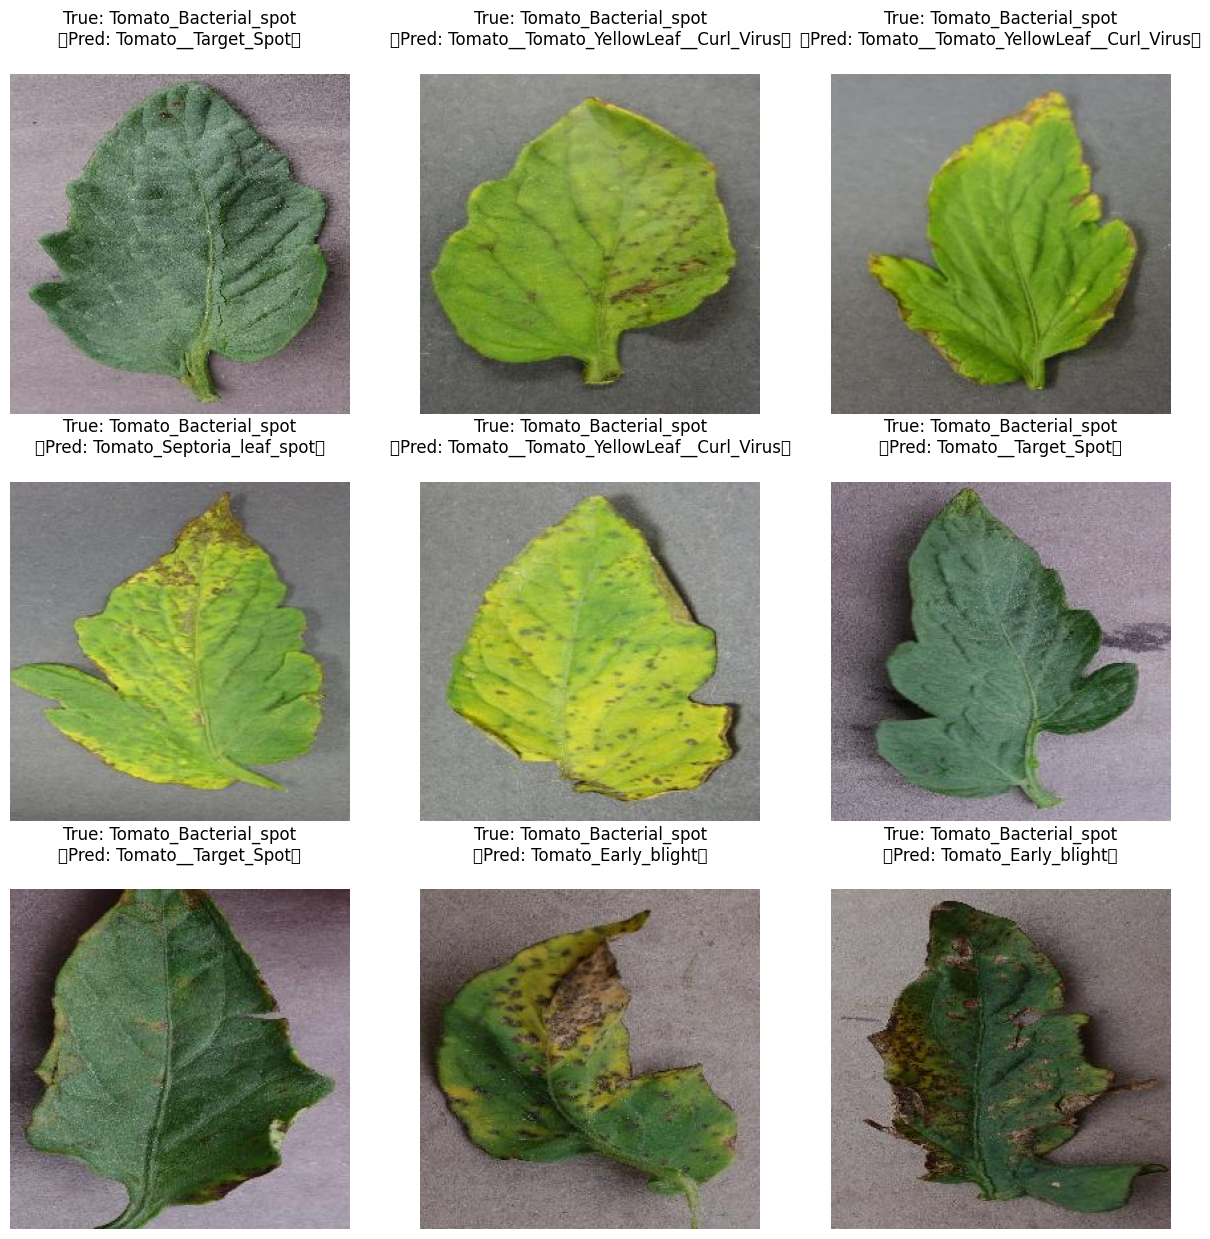

In [ ]:
# Predict labels for the test dataset using test_generator
y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_data.classes  # True labels from the generator

# Get the filenames of misclassified images
misclassified_indices = np.where(y_true != y_pred)[0]
misclassified_filenames = np.array(test_data.filepaths)[misclassified_indices]

# Display misclassified images
num_images = 9  # Number of misclassified images to display
plt.figure(figsize=(15, 15))

for i, idx in enumerate(misclassified_indices[:num_images]):
    # Load image
    img = plt.imread(misclassified_filenames[i])

    # Plot image
    plt.subplot(3, 3, i + 1)  # Adjust layout as needed
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {list(test_data.class_indices.keys())[y_true[idx]]}\n\tPred: {list(test_data.class_indices.keys())[y_pred[idx]]}\t\n")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict labels for the test dataset
y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_data.classes  # True labels from the generator

# Identify misclassified indices and filenames
misclassified_indices = np.where(y_true != y_pred)[0]
misclassified_filenames = np.array(test_data.filepaths)[misclassified_indices]

# Total number of misclassified images
total_misclassified = len(misclassified_indices)
print(f"Total number of misclassified images: {total_misclassified}")

# Set up a grid for displaying images with spacing
num_cols = 3  # Number of columns
num_rows = (total_misclassified + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), constrained_layout=True)

# Add spacing around each image
fig.subplots_adjust(wspace=0.3, hspace=0.3)  # Width and height spacing between images

# Display each misclassified image with true and predicted labels
for i, idx in enumerate(misclassified_indices):
    row, col = divmod(i, num_cols)
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single-row case

    # Load image
    img = plt.imread(misclassified_filenames[i])

    # Show image
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"True: {list(test_data.class_indices.keys())[y_true[idx]]}\nPred: {list(test_data.class_indices.keys())[y_pred[idx]]}", fontsize=10, pad=10)

# Hide any empty subplots (in case total_misclassified is not a multiple of num_cols)
for j in range(i + 1, num_rows * num_cols):
    row, col = divmod(j, num_cols)
    fig.delaxes(axes[row, col])

plt.show()


200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 174ms/step
Total number of misclassified images: 378


<ipython-input-42-d717830df5b8>:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.3, hspace=0.3)  # Width and height spacing between images


Buffered data was truncated after reaching the output size limit.